<a href="https://colab.research.google.com/github/ZakariaBenarbia/Analyse-de-Donnes-Biologiques-ou-de-Sant-avec-POO-et-Pandas/blob/main/programme_POO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload your Excel file for the Male Infertility Dataset (e.g., Male Infertility Data.xlsx):


Saving Male Infertility Data.xlsx to Male Infertility Data (2).xlsx
File 'Male Infertility Data (2).xlsx' uploaded and saved.
Data loaded successfully. Shape: (200, 54)
Data cleaned.
Knowledge_Score computed.
Age_Group computed.

Plotting histogram of Age:


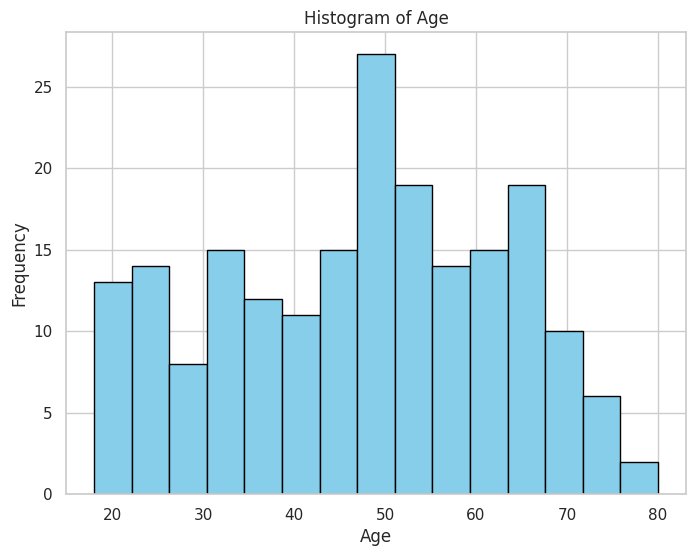


Descriptive Statistics:
               S/N     Consent         Age Ethnicity    Religion  \
count   200.000000  200.000000  200.000000       200  200.000000   
unique         NaN         NaN         NaN        61         NaN   
top            NaN         NaN         NaN      Igbo         NaN   
freq           NaN         NaN         NaN        52         NaN   
mean    100.500000    0.960000   47.295000       NaN    1.265000   
std      57.879185    0.196451   15.436626       NaN    0.453656   
min       1.000000    0.000000   18.000000       NaN    1.000000   
25%      50.750000    1.000000   34.750000       NaN    1.000000   
50%     100.500000    1.000000   48.000000       NaN    1.000000   
75%     150.250000    1.000000   60.250000       NaN    2.000000   
max     200.000000    1.000000   80.000000       NaN    3.000000   

        Relationship status  highest level of education  occupational status  \
count            200.000000                  200.000000           200.000000  

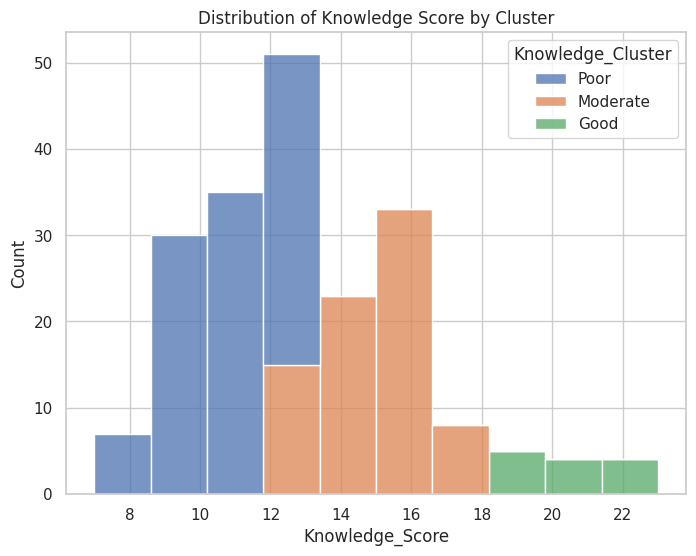

In [ ]:
# Enable inline plotting in Google Colab.
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
from google.colab import files
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# =============================================================================
# DataAnalyzer Class: Chargement et Nettoyage du Dataset
# =============================================================================
class DataAnalyzer:
    """
    Cette classe charge le fichier Excel et nettoie le dataset en remplissant
    les valeurs manquantes (médiane pour les valeurs numériques et mode pour les valeurs catégorielles).
    """
    def __init__(self, filepath):
        self.filepath = filepath
        self.data = None

    def load_data(self):
        """Charge le dataset depuis un fichier Excel."""
        try:
            self.data = pd.read_excel(self.filepath)
            print(f"Data loaded successfully. Shape: {self.data.shape}")
        except Exception as e:
            print("Error loading data:", e)

    def clean_data(self):
        """Nettoie le dataset en remplissant les valeurs manquantes."""
        if self.data is not None:
            numeric_cols = self.data.select_dtypes(include=['int64', 'float64']).columns
            for col in numeric_cols:
                self.data[col] = self.data[col].fillna(self.data[col].median())
            categorical_cols = self.data.select_dtypes(include=['object']).columns
            for col in categorical_cols:
                self.data[col] = self.data[col].fillna(self.data[col].mode()[0])
            print("Data cleaned.")
        else:
            print("Data not loaded.")

    def compute_composite_columns(self):
        """
        Calcule le Knowledge_Score à partir des réponses aux questions Q8 à Q14
        et crée une variable Age_Group à partir de la colonne Age.
        """
        # Compute Knowledge_Score if all seven questions (Q8 to Q14) exist.
        knowledge_questions = ['Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14']
        if all(q in self.data.columns for q in knowledge_questions):
            # Assumption: les réponses sont numériques (0,1, etc.).
            self.data['Knowledge_Score'] = self.data[knowledge_questions].sum(axis=1)
            print("Knowledge_Score computed.")
        else:
            print("Some knowledge question columns are missing; skipping Knowledge_Score computation.")

        # Create Age_Group from Age:
        if 'Age' in self.data.columns:
            bins = [0, 30, 40, 50, 100]
            labels = ['<=30', '31-40', '41-50', '>=51']
            self.data['Age_Group'] = pd.cut(self.data['Age'], bins=bins, labels=labels, right=True)
            print("Age_Group computed.")
        else:
            print("Age column not found; cannot compute Age_Group.")

    def descriptive_statistics(self):
        """Affiche les statistiques descriptives."""
        if self.data is not None:
            print("\nDescriptive Statistics:")
            print(self.data.describe(include="all"))
        else:
            print("Data not loaded.")

    def missing_values_report(self):
        """Affiche le nombre de valeurs manquantes par colonne."""
        if self.data is not None:
            print("\nMissing Values Report:")
            print(self.data.isnull().sum())
        else:
            print("Data not loaded.")

# =============================================================================
# Visualizer Class: Visualisation du Dataset
# =============================================================================
class Visualizer:
    """
    Fournit des méthodes pour tracer des graphiques.
    Ici, j’ai utilisé un histogramme pour explorer les variables et
    pour visualiser la distribution du Knowledge_Score selon le cluster final.
    """
    def __init__(self, dataframe):
        self.data = dataframe
        sns.set(style="whitegrid")

    def plot_histogram(self, column, bins=10):
        """Trace un histogramme pour une colonne numérique."""
        if self.data is not None and column in self.data.columns:
            plt.figure(figsize=(8, 6))
            plt.hist(self.data[column], bins=bins, color='skyblue', edgecolor='black')
            plt.title(f"Histogram of {column}")
            plt.xlabel(column)
            plt.ylabel("Frequency")
            plt.show()
        else:
            print(f"Column {column} not found or data is empty.")

    def plot_knowledge_clusters(self):
        """
        Trace un histogramme du Knowledge_Score en colorant les barres selon le cluster de connaissance.
        """
        if 'Knowledge_Score' not in self.data.columns or 'Knowledge_Cluster' not in self.data.columns:
            print("Required columns not found in data.")
            return

        plt.figure(figsize=(8,6))
        sns.histplot(data=self.data, x="Knowledge_Score", hue="Knowledge_Cluster", multiple="stack", bins=10)
        plt.title("Distribution of Knowledge Score by Cluster")
        plt.xlabel("Knowledge_Score")
        plt.ylabel("Count")
        plt.show()

# =============================================================================
# KnowledgeClustering Class: Clustering sur le Knowledge_Score
# =============================================================================
class KnowledgeClustering:
    """
    Ce module effectue le clustering sur la variable 'Knowledge_Score'
    via KMeans (avec k=3) et attribue à chaque observation un
    label catégoriel ("Poor", "Moderate", "Good") basé sur l'ordre croissant des centroïdes.
    """
    def __init__(self, dataframe):
        self.df = dataframe.copy()
        self.model = None

    def run_clustering(self):
        """Exécute le clustering sur 'Knowledge_Score' seulement."""
        if "Knowledge_Score" not in self.df.columns:
            print("Knowledge_Score column not found.")
            return self.df

        # Extraire la variable Knowledge_Score comme matrice (n,1)
        X = self.df[["Knowledge_Score"]].values

        # Standardisation de la variable
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Exécution de KMeans avec 3 clusters
        self.model = KMeans(n_clusters=3, random_state=42)
        cluster_labels = self.model.fit_predict(X_scaled)

        # Récupération des centroïdes et tri pour assigner le label:
        centroids = self.model.cluster_centers_.flatten()
        sorted_idx = centroids.argsort()  # Le plus petit centroïde = "Poor", le plus grand = "Good"
        label_mapping = { sorted_idx[0]: "Poor",
                          sorted_idx[1]: "Moderate",
                          sorted_idx[2]: "Good" }

        # Création d'une nouvelle colonne Knowledge_Cluster
        self.df["Knowledge_Cluster"] = [label_mapping[label] for label in cluster_labels]
        return self.df

    def print_cluster_frequencies(self):
        """Affiche la distribution en pourcentage des clusters."""
        counts = self.df["Knowledge_Cluster"].value_counts(normalize=True) * 100
        print("\nKnowledge Clustering Results (Distribution in %):")
        print(counts)

# =============================================================================
# Fonction principale : Orchestration
# =============================================================================
def main():
#Téléversement du fichier dans Google Colab.
print("Please upload your Excel file for the Male Infertility Dataset (e.g., Male Infertility Data.xlsx):")
    uploaded = files.upload()
    for fn in uploaded.keys():
        with open(fn, 'wb') as f:
            f.write(uploaded[fn])
        filepath = fn
        print(f"File '{fn}' uploaded and saved.")
        break

    # Chargement et nettoyage du jeu de données.
    analyzer = DataAnalyzer(filepath)
    analyzer.load_data()
    analyzer.clean_data()

    # Calcul des colonnes composites (Knowledge_Score et Age_Group).
    analyzer.compute_composite_columns()

    # Tracé d’un histogramme de l’âge.
    print("\nPlotting histogram of Age:")
    viz = Visualizer(analyzer.data)
    viz.plot_histogram("Age", bins=15)

    # Affichage des statistiques descriptives et du rapport des valeurs manquantes.
    analyzer.descriptive_statistics()
    analyzer.missing_values_report()

    # -----------------------------
    # Knowledge Clustering
    # -----------------------------
    # Exécution du clustering sur le Knowledge_Score afin d’attribuer une étiquette de cluster à chaque observation.
    knowledge_clusterer = KnowledgeClustering(analyzer.data)
    updated_df = knowledge_clusterer.run_clustering()

    # Affichage de la distribution de fréquence des clusters de connaissance.
    knowledge_clusterer.print_cluster_frequencies()

    # Visualisation de la distribution du Knowledge_Score colorée selon les étiquettes de clusters.
    viz_with_clusters = Visualizer(updated_df)
    viz_with_clusters.plot_knowledge_clusters()

# Exécution de la fonction principale.
if __name__ == "__main__":
    main()
